In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib as mpl
from PIL import ImageEnhance
import os
import cv2
import os
import glob
import numpy as np
import pandas as pd
import random
from skimage import io

plt.rcParams.update({'font.size': 14})

In [2]:
%%capture
!tar -xzf NN_Satellite/tiles_256_256_27_test.tar.gz
!tar -xzf NN_Satellite/tiles_256_256_27_train.tar.gz
!tar -xzf NN_Satellite/files.tar.gz

!mv tiles_256_256_27_after_check_test tiles_256_256_27_train

In [3]:
allTiles = list(glob.glob('tiles_256_256_27_test/*/*with_object.tif'))

In [4]:
len(allTiles)

58

In [5]:
img = io.imread(allTiles[0])/65536

img.shape

(256, 256, 27)

/home/ilya/programs/diploma/MapViewApp/backend/env/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


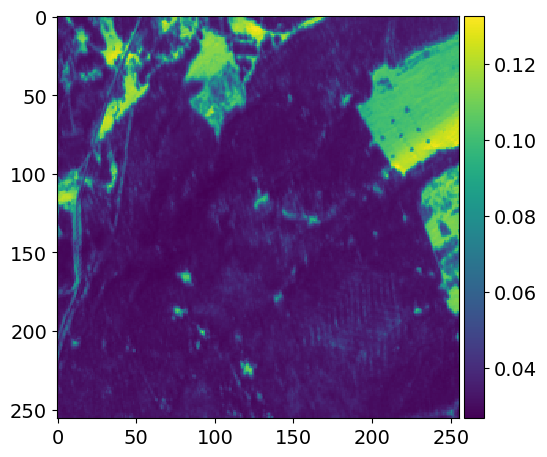

In [6]:
io.imshow(img[:,:,3])

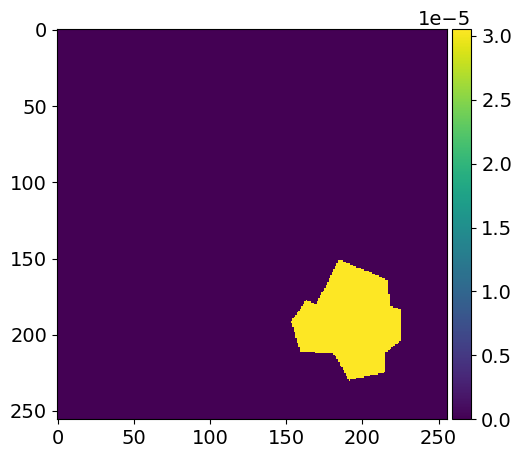

In [7]:
io.imshow(img[:,:,0])

Видим, что изображение - это трёхмерный массив. 256 пикселей по вертикали и по горизонтали, а также 27 каналов "в глубину". Sentinel-2 ведет съёмку не только в 3 привычных каналах видимого спектра (синий, зеленый и красный), но также и в невидимых глазу диапазонах: коротковолновом инфракрасном (SWIR), видимом ближнем инфракрасном (VNIR) и т.д., - всего 13 каналов.

Канал |	Разрешение	| Центральная длина волны |	Описание
--------|--------|--------|--------
B1	| 60 m	| 443 nm	| Ultra Blue (Coastal and Aerosol)
B2	| 10 m	| 490 nm	| Blue
B3	| 10 m	| 560 nm	| Green
B4	| 10 m	| 665 nm	| Red
B5	| 20 m	| 705 nm	| Visible and Near Infrared (VNIR)
B6	| 20 m	| 740 nm	| Visible and Near Infrared (VNIR)
B7	| 20 m	| 783 nm	| Visible and Near Infrared (VNIR)
B8	| 10 m	| 842 nm	| Visible and Near Infrared (VNIR)
B8a	| 20 m	| 865 nm	| Visible and Near Infrared (VNIR)
B9	| 60 m	| 940 nm	| Short Wave Infrared (SWIR)
B10	| 60 m	| 1375 nm   | Short Wave Infrared (SWIR)
B11	| 20 m	| 1610 nm   | Short Wave Infrared (SWIR)
B12	| 20 m	| 2190 nm   | Short Wave Infrared (SWIR)


В наших данных заранее совмещены пары старых снимков (со все ещё с нетронутым лесом) и новых (с повреждением), а также маска (с отмеченным повреждением). Так что всего получается 13+13+1=27 каналов. Порядок их следования в нашем трехмерном массиве следующий:

    Маска - 0
    Новый снимок
    ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
    [ 1,     2,    3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13  ]
    Старый снимок
    ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
    [ 14,    15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26  ];

В маске разными цифрами указаны следующие классы:
*   1 - Сплошная рубка
*   2 - Проходная рубка
*   3 - Лесная дорога
*   4 - Ветровал
*   5 - Пожар
*   6 - Усыхание (повреждение)
*   7 - Выборочная рубка

Мы собираемся обучать модели всего лишь для бинарной сегментации, так что достаточно будет проверить, больше ли нуля значение маски.

In [8]:
len(allTiles)

58

In [9]:

def get_rgb_new(img):
    c1 = 4
    c2 = 3
    c3 = 2
    img = np.stack([img[::, ::, c1] / img[::, ::, c1].max() ,
                img[::, ::, c2] / img[::, ::, c2].max(),
                img[::, ::, c3] / img[::, ::, c3].max()], axis=2)
    return img

def get_rgb_old(img):
    c1 = 17
    c2 = 16
    c3 = 15
    img = np.stack([img[::, ::, c1] / img[::, ::, c1].max() ,
                img[::, ::, c2] / img[::, ::, c2].max(),
                img[::, ::, c3] / img[::, ::, c3].max()], axis=2)
    return img


def show_mask(data, k):
    labels =['Background',"Damaged forest","Damaged forest","Damaged forest"
             ,"Damaged forest","Damaged forest","Damaged forest","Damaged forest"] # ['', 'Сплошная рубка', 'Проходная рубка', 'Лесная дорога', 'Ветровал', 'Пожар', 'Усыхание', 'Выборочная рубка']
    my_colors = ['black', 'white', 'white', 'white', 'white', 'white', 'white', 'white']
    cmap = colors.ListedColormap(my_colors)
    bounds=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    values = np.unique(data.ravel()).astype(int)
    im = plt.imshow(X=data, cmap=cmap, norm=norm)

    patches = [ mpatches.Patch(color=my_colors[values[i]],
                               label=f"{labels[values[i]]}" ) for i in range(len(values)) ] #
    # patches = ["Damaged forest"]
    axes[k].legend(loc="lower left", handles=patches,  fontsize=40)
    axes[k].set_title('Mask', fontsize=70,weight='bold')
    axes[k].axis('off')

def show_img_norm(img, k):
    img = (img*255).astype(np.uint8)
    img = Image.fromarray(img, 'RGB')

    enhancer = ImageEnhance.Brightness(img)
    factor = 0.8
    im_output = enhancer.enhance(factor)

    enhancer = ImageEnhance.Contrast(im_output)
    factor = 1.3
    im_output = enhancer.enhance(factor)

    axes[k].imshow(im_output)
    axes[k].axis('off')

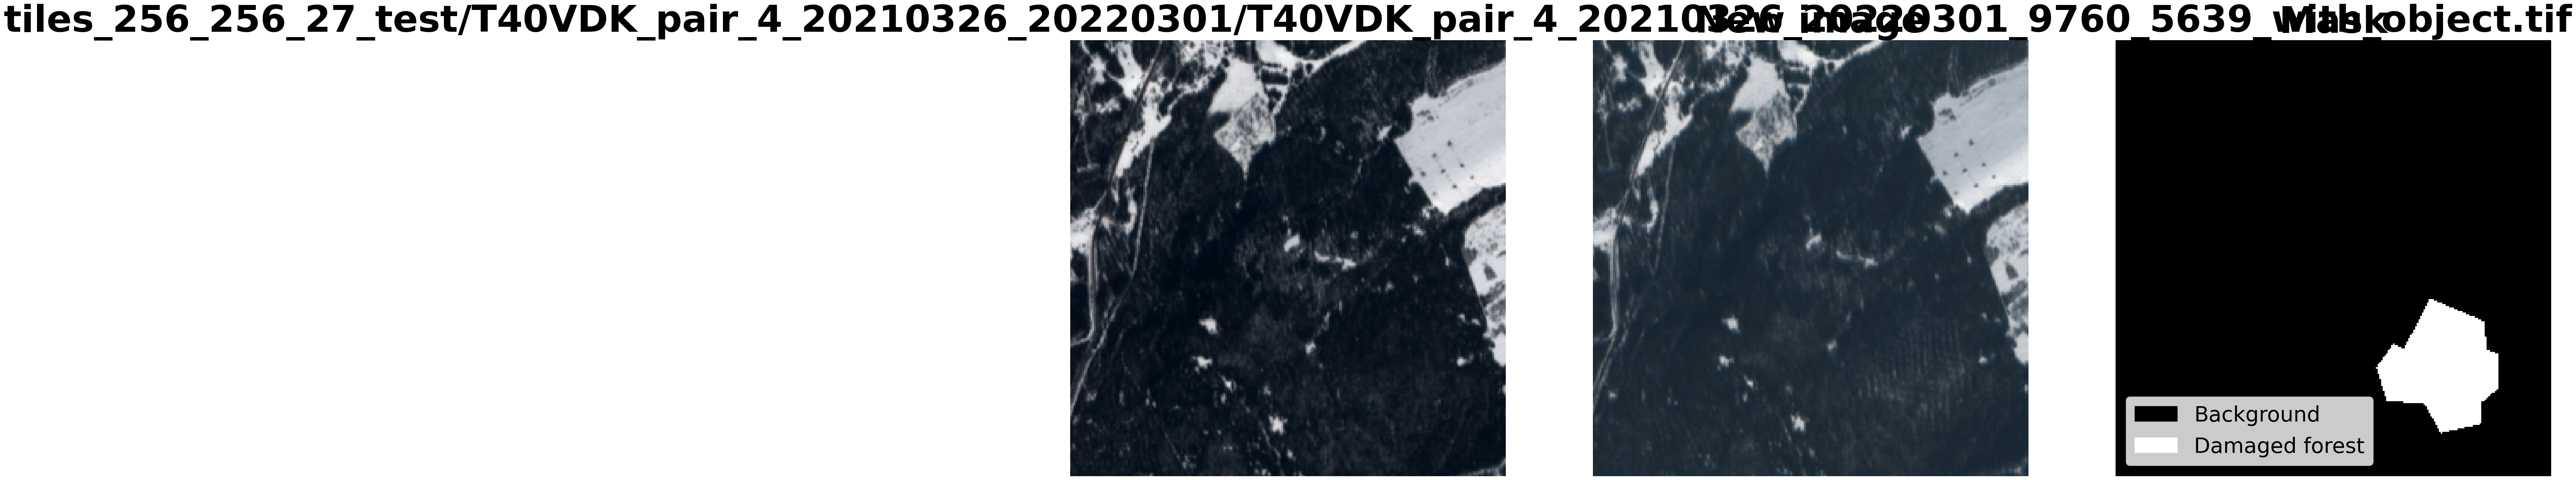

In [12]:
for i,tileS in enumerate(allTiles):# random.sample(allTiles, 5):
    img = io.imread(tileS)

    fig,axes = plt.subplots(ncols=3,figsize=(50,50))
    plt.title(os.path.basename(tileS))

    show_img_norm(get_rgb_old(img), 0)
    axes[0].set_title('Old image',fontsize=70,weight='bold')

    show_img_norm(get_rgb_new(img), 1)
    axes[1].set_title('New image', fontsize=70,weight='bold')

    show_mask( img[:,:,0], 2)

    print(tileS)


Unet

In [11]:
# import torch
import tensorflow as tf
import tensorflow.keras.backend as K

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
MODELS_PATH = r'models_UNet/files/files/'

In [ ]:
model = tf.keras.models.load_model(MODELS_PATH + 'model_unet.h5', compile=False)

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IoU(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
testTiles = list(glob.glob('tiles_256_256_27_test/*/*.tif'))
len(testTiles)

117

In [ ]:
# тут рассчитываем входные признаки (производные или исходные и т.д.)
def prepare_snaps(img):
    return np.array(
            np.dstack([
                    img[:,:,4],
                    img[:,:,8],
                    img[:,:,17],
                    img[:,:,21],
                    img[:,:,4] - img[:,:,17], # dif red
                    img[:,:,17] - img[:,:,4], # dif for transitionChange
                    img[:,:,8] - img[:,:,21],
                    img[:,:,21] - img[:,:,8],
                    img[:,:,13],
                    img[:,:,26],
                    img[:,:,13] - img[:,:,26],
                    img[:,:,26] - img[:,:,13], # dif for transitionChange
                    img[:,:,12], # dif for transitionChange
                    img[:,:,25], # dif for transitionChange
                    img[:,:,12] - img[:,:,25], # dif for transitionChange
                    img[:,:,25] - img[:,:,12],
                ])).astype('float32')
def round_original(a):
    new = [1 if i > 0 else 0 for i in a]
    return np.array (new)

def predict(model, testTiles, num_models=1):
  print(num_models)
  original_list = []

  original_img_list = []

  predict_mask_list = []

  for testImg in testTiles:
      img = io.imread(testImg)
      original_img_list.append( img )
      img = img /65536
      original_list.append( np.apply_along_axis( round_original, 1, img[:,:,0] ).astype('float32') )

      toPredict = prepare_snaps(img)

      if num_models==1:
        testPrediction = model.predict(np.array([toPredict]));
      else:
        print('here')
        testPrediction = model.predict([np.array([toPredict]) for _ in range(num_models) ]);

      predict_mask_list.append(testPrediction[0,:,:,0].astype('float32'))

  dice = dice_coefficient(original_list, predict_mask_list)
  iou = IoU(original_list, predict_mask_list)

  return dice, iou, original_img_list, predict_mask_list

In [ ]:
len(testTiles), testTiles[0]

(117,
 'tiles_256_256_27_test\\T35WPQ_pair_0_20170702_20180702\\T35WPQ_pair_0_20170702_20180702_6297_7200_with_object.tif')

In [ ]:
%%capture
dice,iou, original_img_list, predict_mask_list = predict(model, testTiles);

In [ ]:
dice, iou

(<tf.Tensor: shape=(), dtype=float32, numpy=0.7560179233551025>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6077409386634827>)

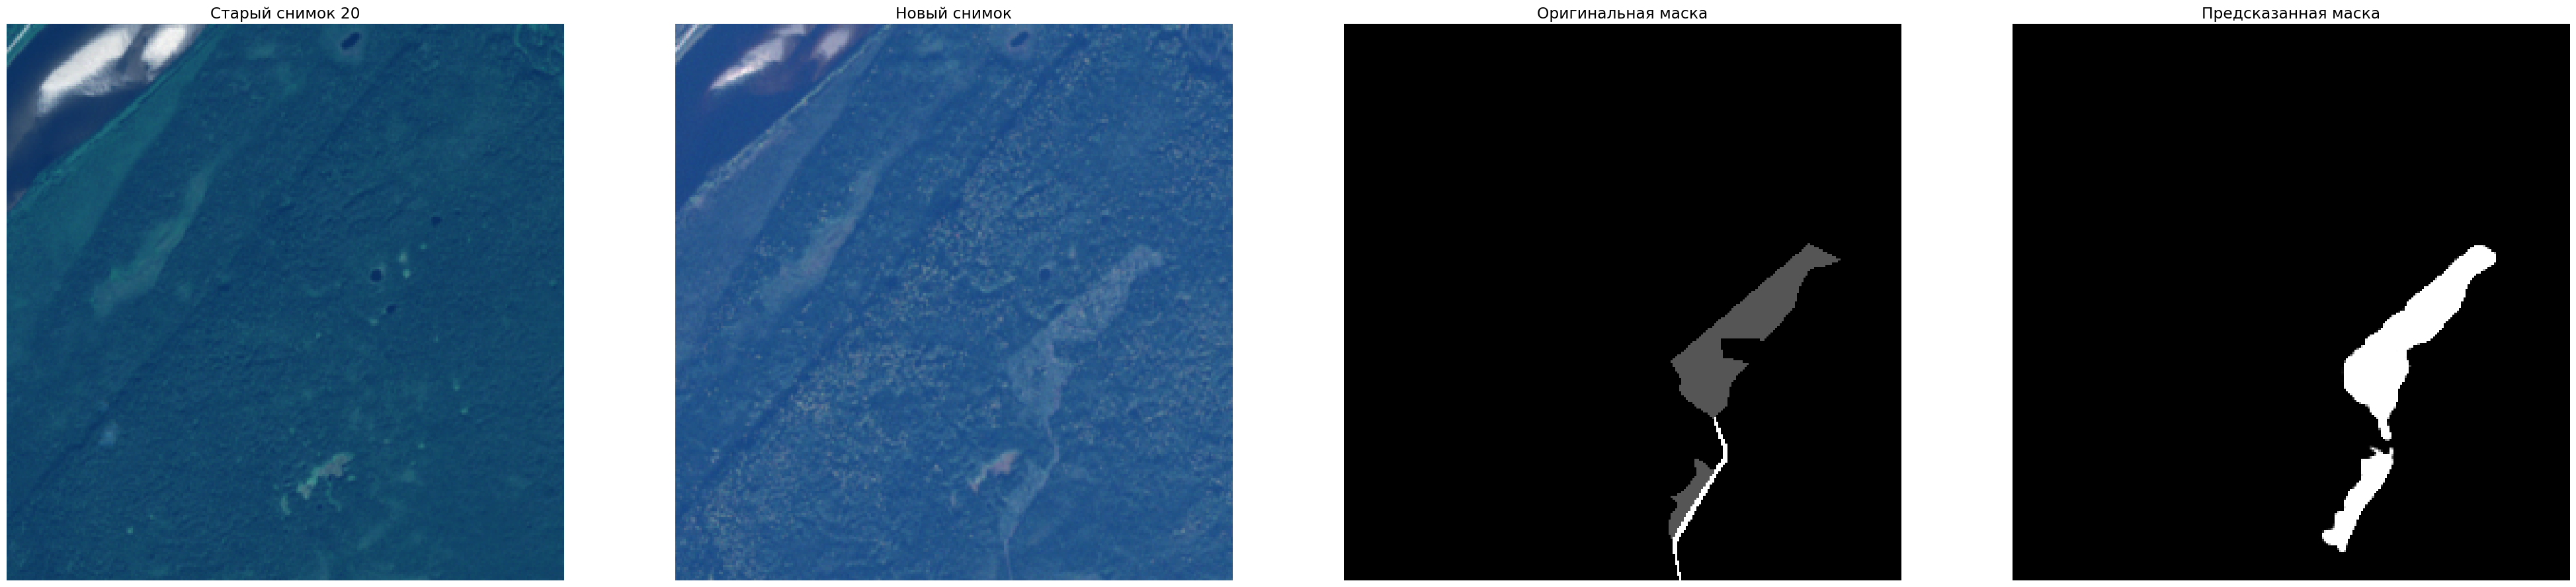

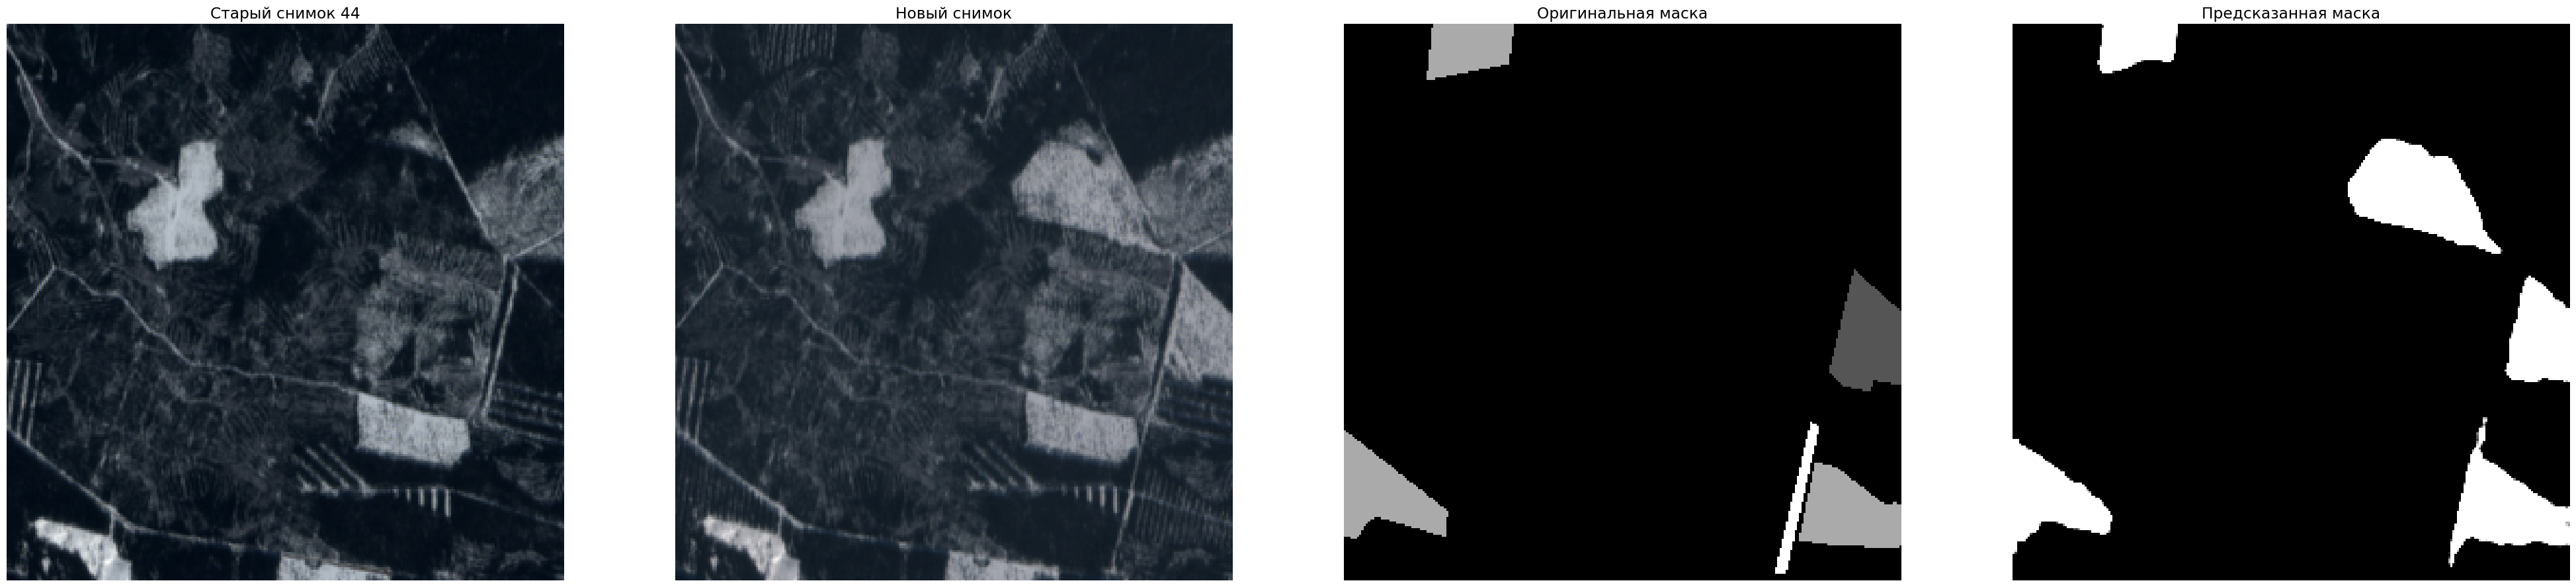

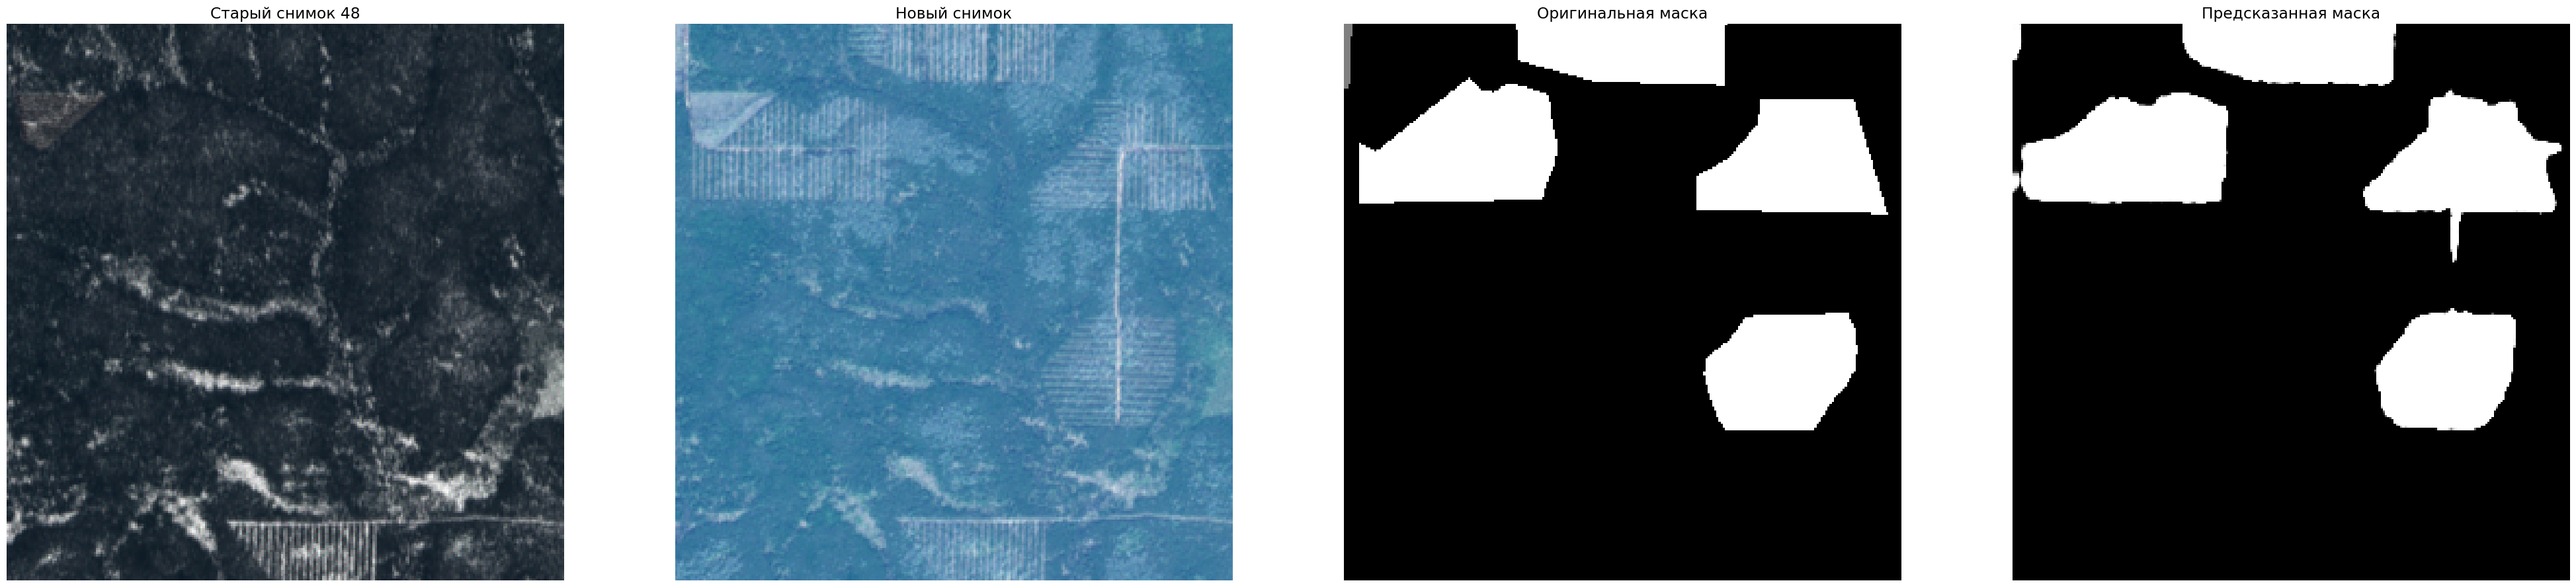

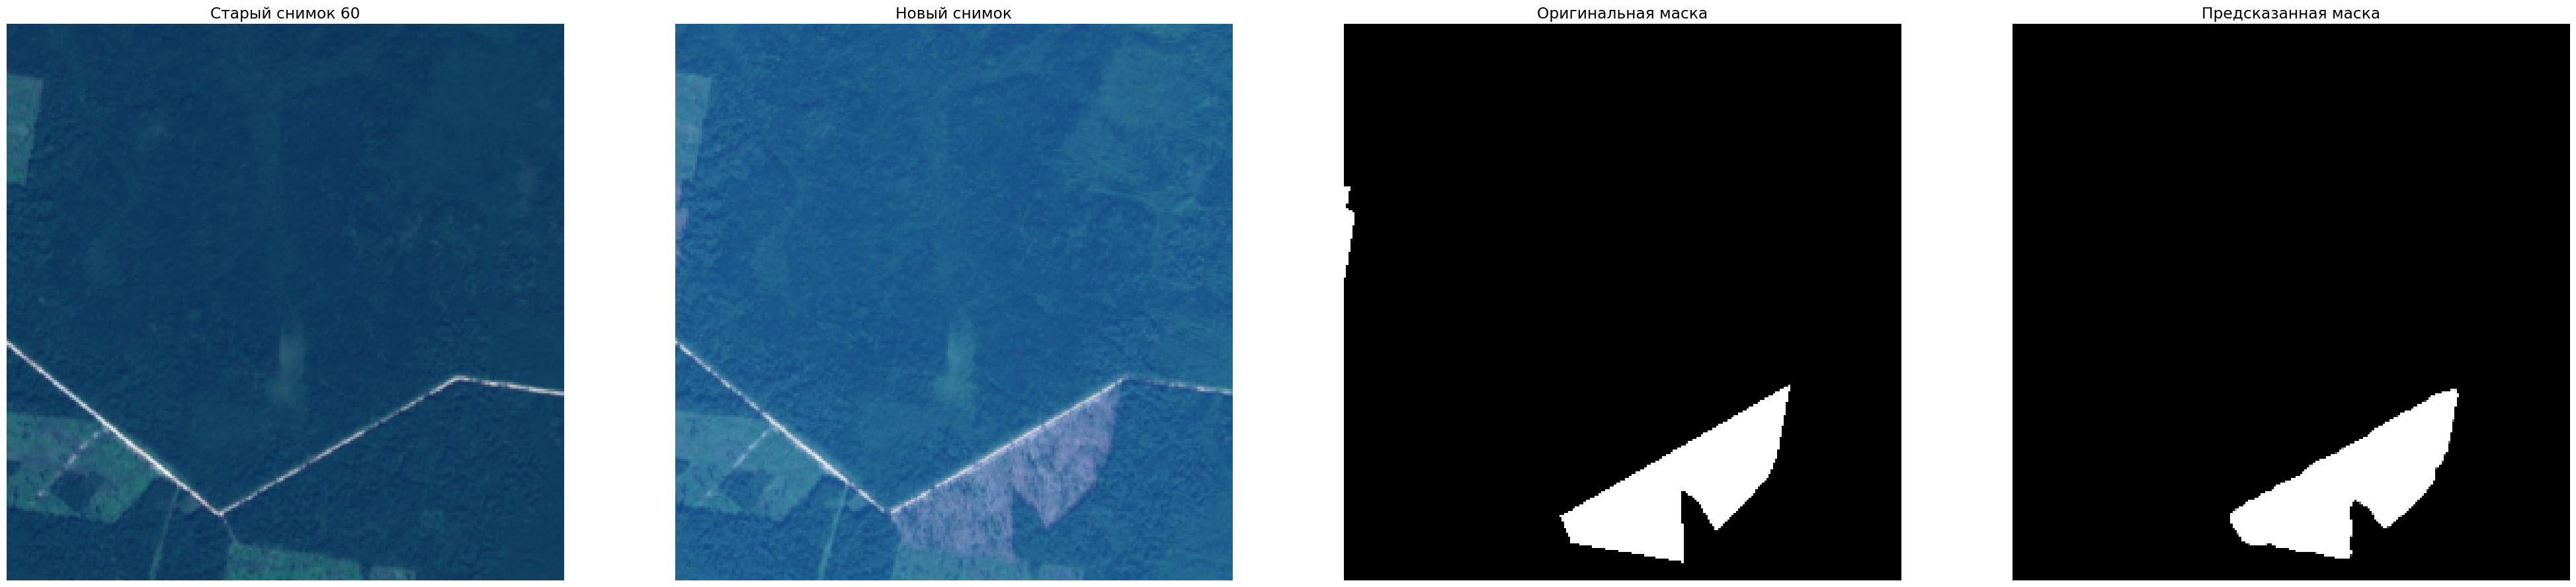

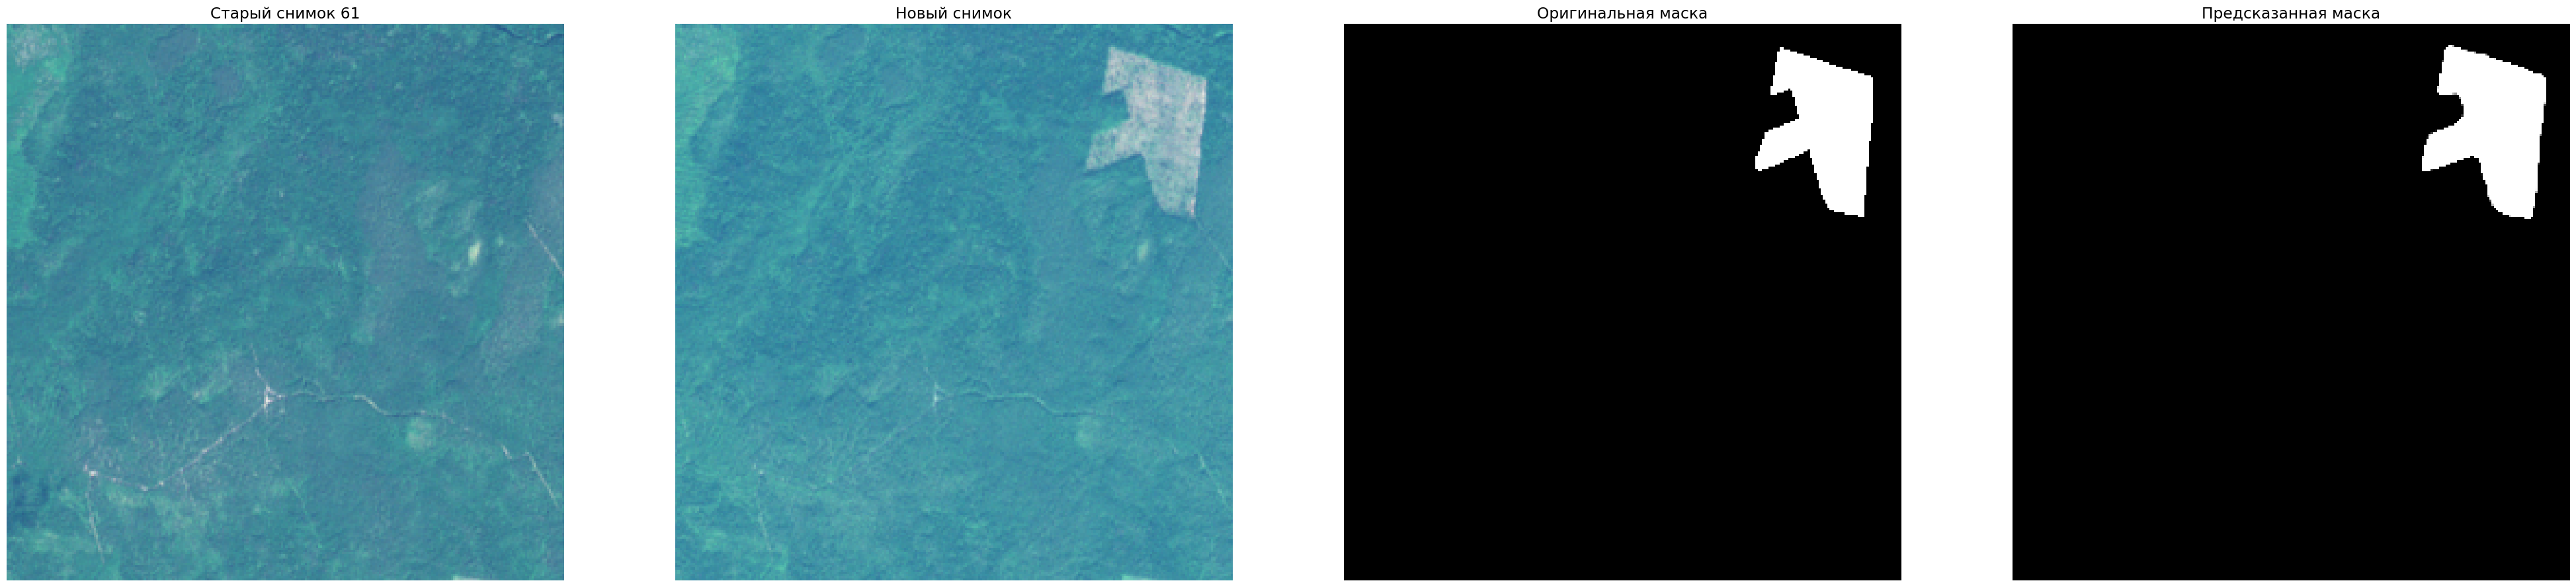

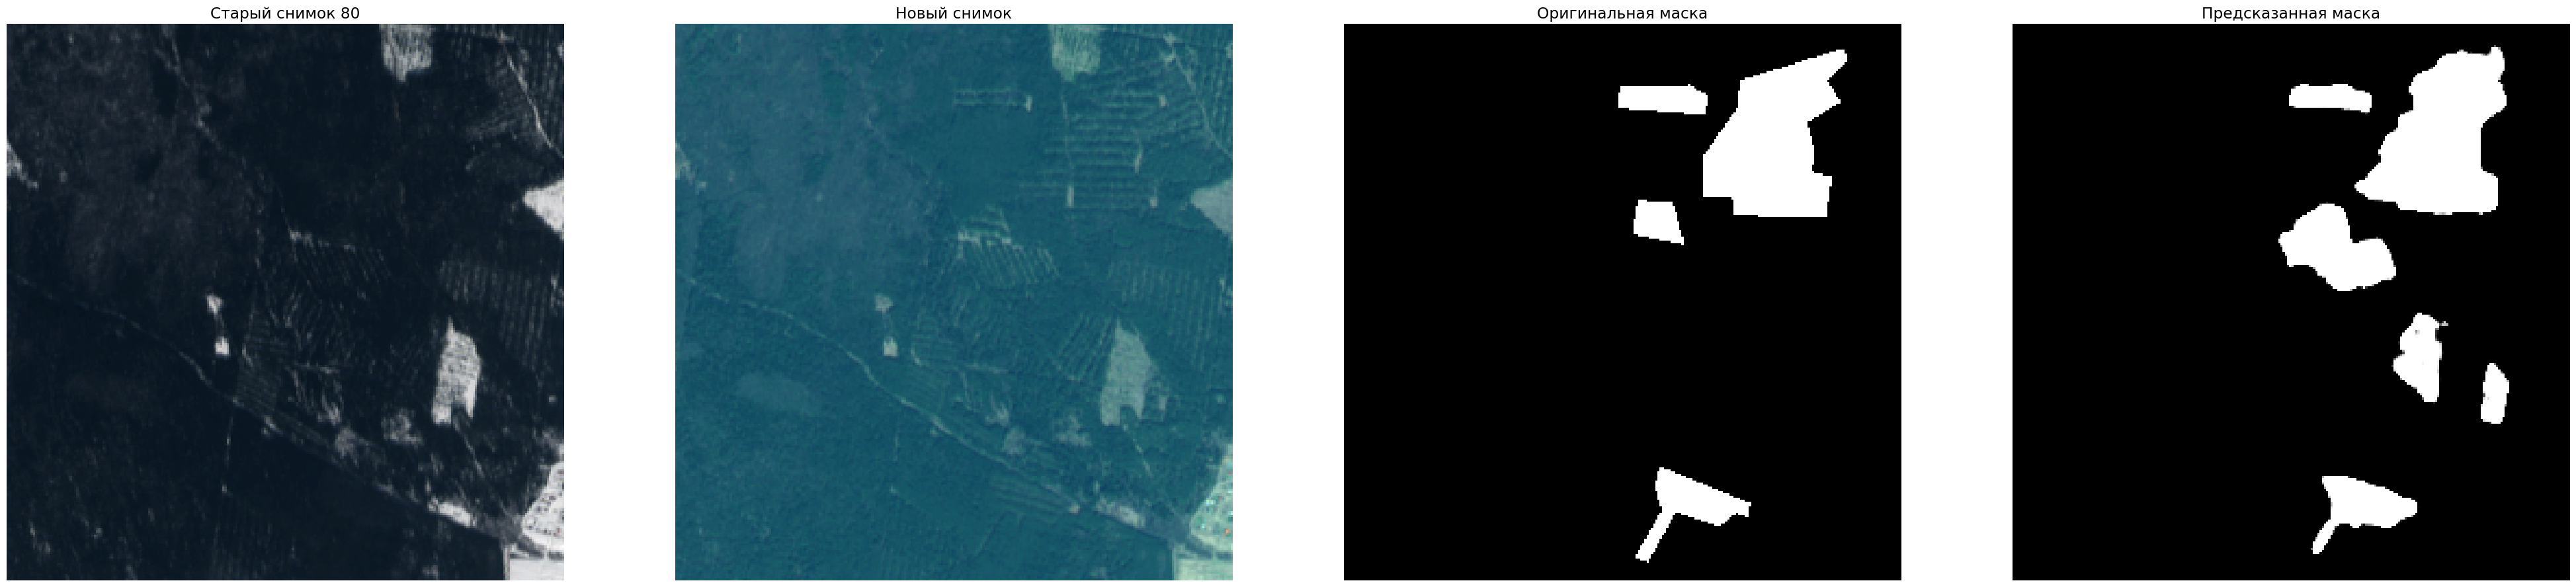

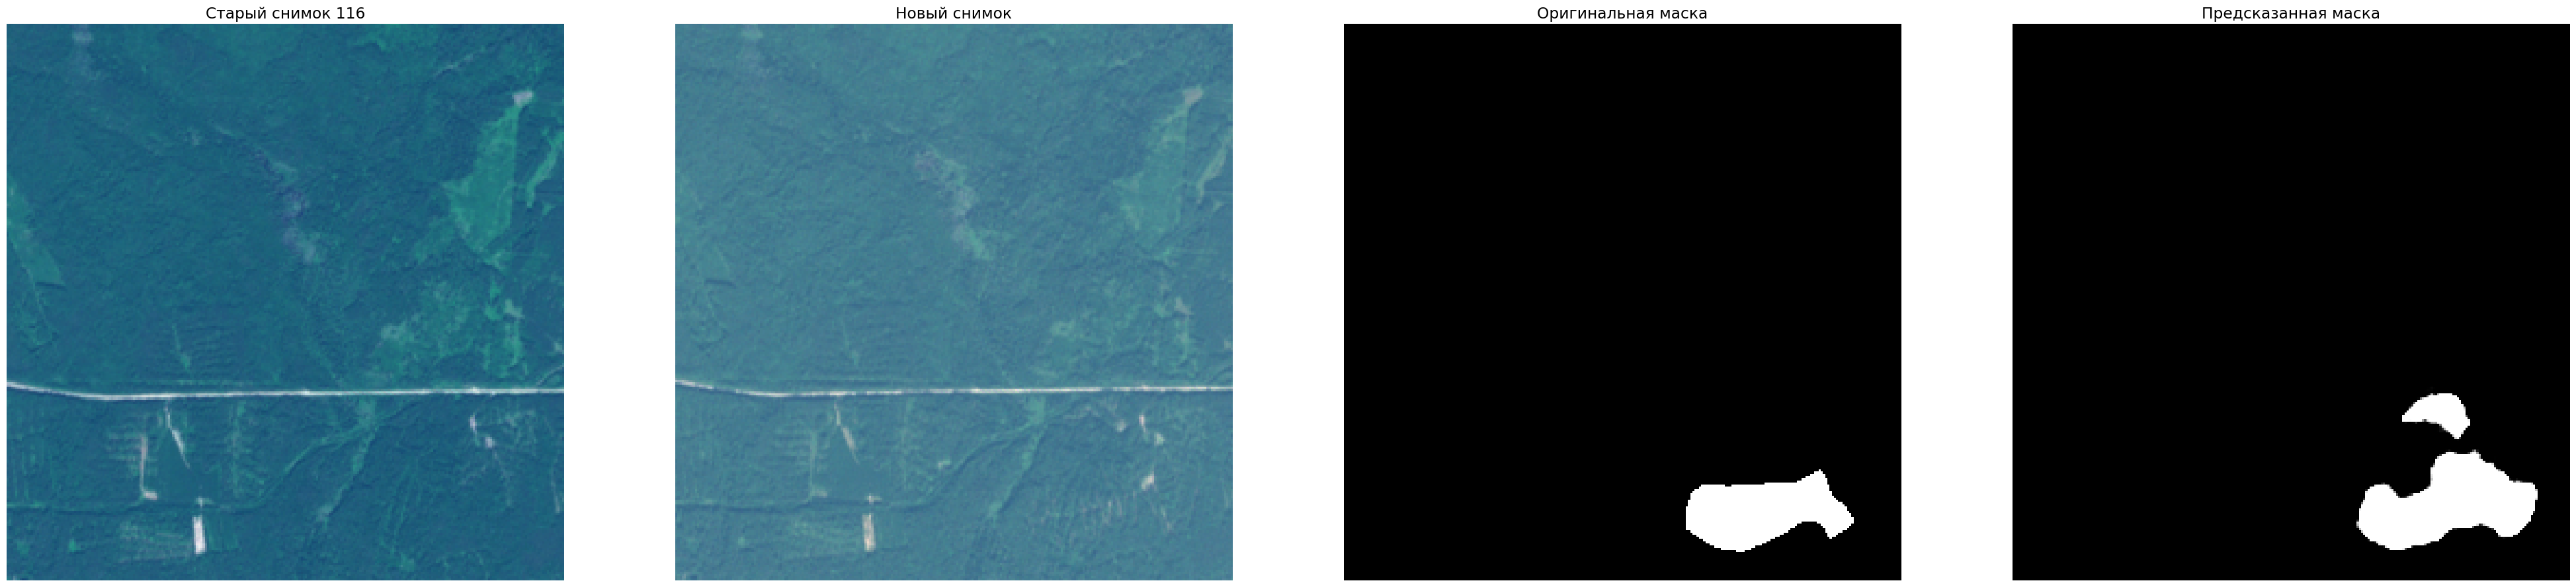

In [ ]:
offset = 0 #58
for i in [20,44,48,60,61,80,116]:

    fig,axes = plt.subplots(ncols=4,figsize=(50,50))

    show_img_norm(get_rgb_old(original_img_list[i+offset]), 0)
    axes[0].set_title(f'Старый снимок {i}')

    show_img_norm(get_rgb_new(original_img_list[i+offset]), 1)
    axes[1].set_title('Новый снимок')

    axes[2].imshow(original_img_list[i+offset][:,:,0].astype('float32'), cmap="gray")
    axes[2].set_title('Оригинальная маска')
    axes[2].axis('off')

    axes[3].imshow(predict_mask_list[i+offset].astype('float32'), cmap="gray")
    axes[3].set_title('Предсказанная маска')
    axes[3].axis('off')

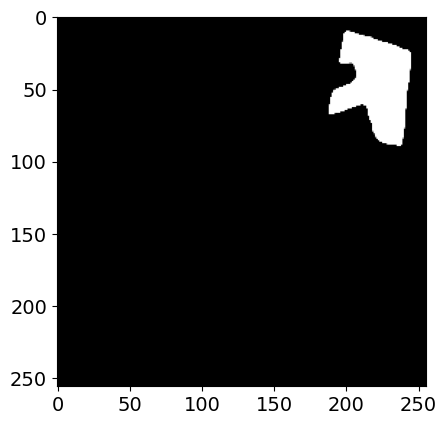

In [ ]:
idx = 61
plt.imshow(predict_mask_list[idx], cmap='gray', vmin=0, vmax=1)

In [ ]:
len(predict_mask_list), predict_mask_list[0].shape

(117, (256, 256))

In [ ]:
dice_coefficient(predict_mask_list[idx],predict_mask_list[idx])

<tf.Tensor: shape=(), dtype=float32, numpy=0.9978647232055664>

In [ ]:
predict_mask_list[idx].dtype

dtype('float32')

In [ ]:
predict_mask_list[idx].shape

(256, 256)

In [ ]:
(predict_mask_list[idx]*65536).astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

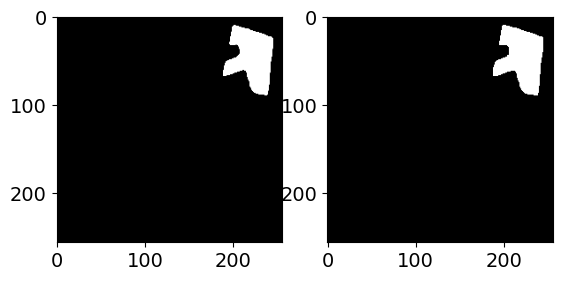

In [ ]:

idx = 61
# plt.plot(predict_mask_list[idx])

fig, ax = plt.subplots(1,2)

ax[0].imshow((predict_mask_list[idx]), cmap="gray")
test_mask = (predict_mask_list[idx]*65536).astype(int )
test_mask[test_mask>1]=1

ax[1].imshow( test_mask, cmap="gray")
plt.show()

In [ ]:

test_mask[test_mask==1].shape, test_mask[test_mask==0].shape

((2848,), (62688,))

In [ ]:
np.unique(test_mask)

array([0, 1])

In [ ]:
#for finding countours
from skimage import measure

In [ ]:
def get_contours(mask,level = 0.5):
    contours = measure.find_contours(mask, level=level)
    for contour in contours:
        for i in range(contour.shape[0]):
            contour[i,1], contour[i,0] =  contour[i,0], contour[i,1]
    
    return contours

[array([[238. ,  89.5],
       [237. ,  89.5],
       [236. ,  89.5],
       [235. ,  89.5],
       [234. ,  89.5],
       [233.5,  89. ],
       [233. ,  88.5],
       [232. ,  88.5],
       [231. ,  88.5],
       [230. ,  88.5],
       [229. ,  88.5],
       [228. ,  88.5],
       [227. ,  88.5],
       [226.5,  88. ],
       [226. ,  87.5],
       [225. ,  87.5],
       [224. ,  87.5],
       [223.5,  87. ],
       [223. ,  86.5],
       [222.5,  86. ],
       [222. ,  85.5],
       [221.5,  85. ],
       [221. ,  84.5],
       [220.5,  84. ],
       [220. ,  83.5],
       [219.5,  83. ],
       [219.5,  82. ],
       [219. ,  81.5],
       [218.5,  81. ],
       [218.5,  80. ],
       [218. ,  79.5],
       [217.5,  79. ],
       [217.5,  78. ],
       [217.5,  77. ],
       [217.5,  76. ],
       [217.5,  75. ],
       [217. ,  74.5],
       [216.5,  74. ],
       [216.5,  73. ],
       [216. ,  72.5],
       [215.5,  72. ],
       [215.5,  71. ],
       [215.5,  70. ],
       [21

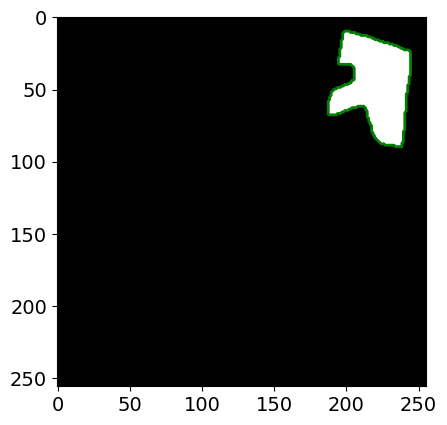

In [ ]:
contours = get_contours(test_mask)

print(contours)

fig, ax = plt.subplots()
ax.imshow(test_mask, cmap="gray")

for contour in contours:
    # print(contour.shape)
    # break
    ax.plot(contour[:,0], contour[:, 1], linewidth=2, color="green")

plt.show()

In [ ]:
test_contour = contours[0]
test_contour.shape
# contours

(309, 2)

In [ ]:
from simplification.cutil import simplify_coords, simplify_coords_vw


(11, 2) (27, 2)


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

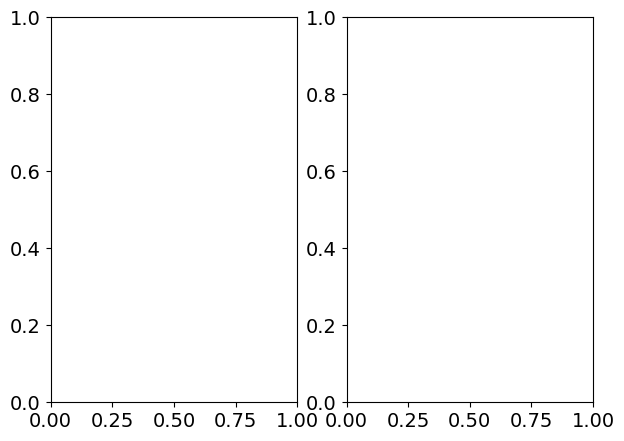

In [ ]:
tolerance = 5
polygon_dp = simplify_coords(test_contour,tolerance) #Дуглас-Пеккер
polygon_vw = simplify_coords_vw(test_contour,tolerance) #Висвалингам-Уатт
print(polygon_dp.shape, polygon_vw.shape)

fig, ax = plt.subplots(1,2,figsize=(7,5))
ax.imshow(test_mask,cmap="gray")
ax.plot(polygon_dp[:,0], polygon_dp[:,1],linewidth=3)

ax[1].imshow(test_mask, cmap="gray")
ax[1].plot(polygon_vw[:,0], polygon_vw[:,1],linewidth=3)
plt.show()

In [ ]:
%%timeit
simplify_coords(test_contour,5) #Дуглас-Пеккер


15 μs ± 1.83 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%%timeit
simplify_coords_vw(test_contour,5) #Висвалингам-Уатт

43.7 μs ± 5.77 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
polygon_dp

array([[238. ,  89.5],
       [219.5,  83. ],
       [212. ,  61.5],
       [187.5,  67. ],
       [189.5,  52. ],
       [205.5,  43. ],
       [203. ,  32.5],
       [194.5,  32. ],
       [199. ,   9.5],
       [244.5,  24. ],
       [238. ,  89.5]])

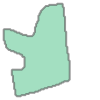

In [ ]:
from shapely.geometry import Polygon
Polygon(test_contour)

для замера метрик нужно заново заливать полигон - то есть делать из него маску

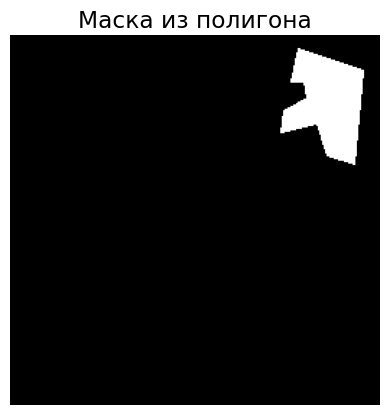

In [ ]:
import cv2

polygon = np.array(polygon_dp, dtype=np.int32)
mask = np.zeros((256,256), dtype=np.uint8)
cv2.fillPoly(mask, [polygon], color=1)


plt.imshow(mask, cmap="gray")
plt.title("Маска из полигона")
plt.axis("off")
plt.show()


In [ ]:
test_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
from tqdm import tqdm 

def jaccard_score(y_true, y_pred):
    denominator = np.sum(np.logical_or(y_true, y_pred))
    if denominator==0:
        return 0
    return np.sum(np.logical_and(y_true, y_pred)) / denominator

def dice_coefficient(y_true, y_pred): 
    denominator = (np.sum(y_true) + np.sum(y_pred))
    if denominator==0:
        return 0
    return 2. * (np.sum(np.logical_and(y_true, y_pred))) /denominator


def normalize_mask(mask):
    mask =  (mask*65536).astype(int)
    mask[mask>1]=1
    return mask


def get_metrics(mask, tolerance_dp, tolerance_vw):
    mask = normalize_mask(mask)  
    num_points_mask = np.sum(mask[mask==1])
    contours = get_contours(mask)
    # fig, ax = plt.subplots()
    # ax.imshow(mask)
    # for contour in contours:
    #     # print(contour.shape)
    #     # break
    #     ax.plot(contour[:,0], contour[:, 1], linewidth=2, color="green")
    # #  ax[1].imshow(mask)
    
    if len(contours)==0:
        return None
    

    all_contours_on_mask = np.zeros((256,256), dtype=np.uint8)
    all_contours_dp = np.zeros((256,256), dtype=np.uint8)
    all_contours_vm = np.zeros((256,256), dtype=np.uint8)

    num_points_dp_curr = []
    num_points_vw_curr = []

    #внутри каждого tile может быть несколько масок
    for contour in contours:
        polygon_dp = simplify_coords (contour,tolerance_dp) 
        polygon_vw = simplify_coords_vw (contour,tolerance_vw) 
        #собираем количество точек
        num_points_dp_curr.append(polygon_dp.shape[0])
        num_points_vw_curr.append(polygon_vw.shape[0])

        # print(polygon_dp.shape[0])
        #для замера метрик заполнили полигоны
        curr_mask =np.zeros((256,256), dtype=np.uint8)
        cv2.fillPoly(curr_mask, [np.array(contour, dtype=np.int32)], color=1)
        
        mask_dp = np.zeros((256,256), dtype=np.uint8)
        cv2.fillPoly(mask_dp, [np.array(polygon_dp, dtype=np.int32)], color=1)

        mask_vw = np.zeros((256,256), dtype=np.uint8)
        cv2.fillPoly(mask_vw, [np.array(polygon_vw, dtype=np.int32)], color=1)

        all_contours_on_mask = np.logical_or(all_contours_on_mask, curr_mask)
        all_contours_dp= np.logical_or(all_contours_dp, mask_dp)
        all_contours_vm= np.logical_or(all_contours_vm, mask_vw)
        # fig, ax = plt.subplots(1,3)
        # ax[0].imshow(all_contours_on_mask)
        # ax[1].imshow(all_contours_dp)
        # ax[2].imshow(all_contours_vm)
        # ax[0].axis('off')
        # ax[1].axis('off')
        # ax[2].axis('off')
        # print(np.unique(mask_vw), np.unique(mask))

    return num_points_mask, all_contours_on_mask, all_contours_dp, all_contours_vm, num_points_dp_curr, num_points_vw_curr



def get_metrics_all(predict_mask_list, tolerance_dp, tolerance_vw, logging=True):
 
    #собираем метрики
    dice_dp,dice_vw = [], []
    iou_dp, iou_vw = [], []
    #собираем количество точек на выходе
    num_points_dp, num_points_vw = [], []

    num_points_mask = []
    for mask in tqdm(predict_mask_list, disable= (not logging) ):
        
        result = get_metrics(mask, tolerance_dp, tolerance_vw)
        if result==None:
            continue

        num_points_mask_curr, all_contours_on_mask, all_contours_dp, all_contours_vm, num_points_dp_curr, num_points_vw_curr = result


        dice_dp.append( dice_coefficient(all_contours_on_mask,all_contours_dp) )
        dice_vw.append( dice_coefficient(all_contours_on_mask,all_contours_vm))

        iou_dp.append( jaccard_score(all_contours_on_mask,all_contours_dp) )
        iou_vw.append( jaccard_score(all_contours_on_mask,all_contours_vm))

        num_points_dp.append(sum(num_points_dp_curr)/len(num_points_dp_curr))
        num_points_vw.append(sum(num_points_vw_curr)/len(num_points_vw_curr))

        # print(dice_dp,dice_vw, iou_dp, iou_vw,sep ='\n')
        num_points_mask.append(num_points_mask_curr)
        # break


    return {
            "num_points_mask" : np.mean(np.array(num_points_mask)).astype(int),
            'dice_dp': np.mean(np.array(dice_dp)),
            'iou_dp' : np.mean(np.array(iou_dp)),
            'num_points_dp' : np.mean(np.array(num_points_dp)).astype(int),

            'dice_vw': np.mean(np.array(dice_vw)),
            'iou_vw' : np.mean(np.array(iou_vw)),
            'num_points_vw' : np.mean(np.array(num_points_vw)).astype(int),
            }

    
get_metrics_all(predict_mask_list, tolerance_dp=0, tolerance_vw=0)

100%|██████████| 117/117 [00:00<00:00, 399.13it/s]


{'num_points_mask': 3401,
 'dice_dp': 1.0,
 'iou_dp': 1.0,
 'num_points_dp': 121,
 'dice_vw': 1.0,
 'iou_vw': 1.0,
 'num_points_vw': 121}

In [ ]:
x = np.arange(0,20.05,0.05)

dice_dp,dice_vw = [],[]
iou_dp, iou_vw = [],[]

num_points_dp, num_points_vw = [], []
for x_i in tqdm(x.tolist()):
    res = get_metrics_all(predict_mask_list, tolerance_dp = x_i, tolerance_vw = x_i, logging=False)
    dice_dp.append(res['dice_dp'])
    dice_vw.append(res['dice_vw'])

    iou_dp.append(res['iou_dp'])
    iou_vw.append(res['iou_vw'])


    num_points_dp.append(res['num_points_dp'])
    num_points_vw.append(res['num_points_vw'])


toArr = lambda x: np.array(x)
dice_dp,dice_vw = toArr(dice_dp),toArr(dice_vw)
iou_dp, iou_vw = toArr(iou_dp), toArr(iou_vw) 

num_points_dp, num_points_vw = toArr(num_points_dp), toArr(num_points_vw)


100%|██████████| 401/401 [02:21<00:00,  2.84it/s]


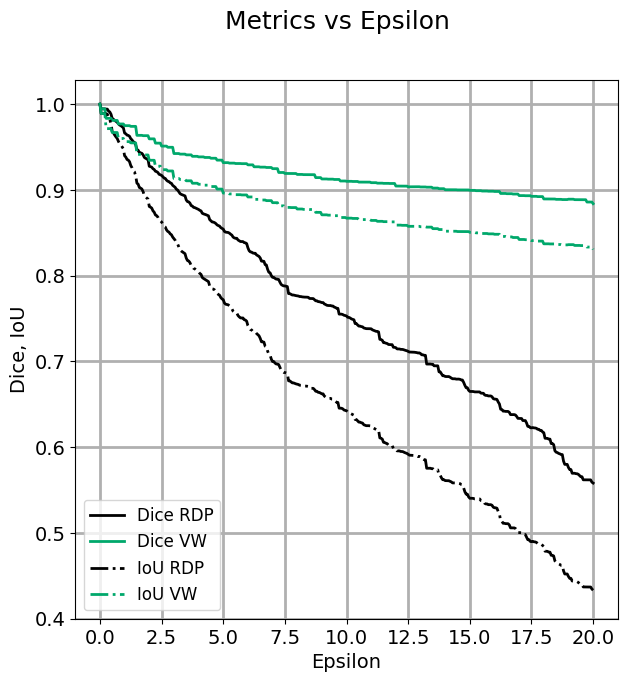

In [ ]:


# Create subplots
fig, ax = plt.subplots(figsize=(7, 7))

# Plot data
ax.plot(x, dice_dp, label="Dice RDP", color='black', linestyle='-', linewidth=2)
ax.plot(x, dice_vw, label="Dice VW", color='#00a86b', linestyle='-', linewidth=2)

ax.set_xlabel("Epsilon", fontsize=14)
ax.set_ylabel("Dice, IoU", fontsize=14)
# ax.set_title("Dice Coefficient", fontsize=16)

ax.plot(x, iou_dp, label="IoU RDP", color='black', linestyle='-.', linewidth=2)
ax.plot(x, iou_vw, label="IoU VW", color='#00a86b', linestyle='-.', linewidth=2)
ax.legend(fontsize=12)
ax.set_xlabel("Epsilon", fontsize=14)
# ax.set_title("", fontsize=16)
ax.set_ylim(0.4)
ax.grid(True,linewidth = 2)
ax.legend(fontsize=12)

# Add a common title
fig.suptitle("Metrics vs Epsilon", fontsize=18)

# Adjust layout
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

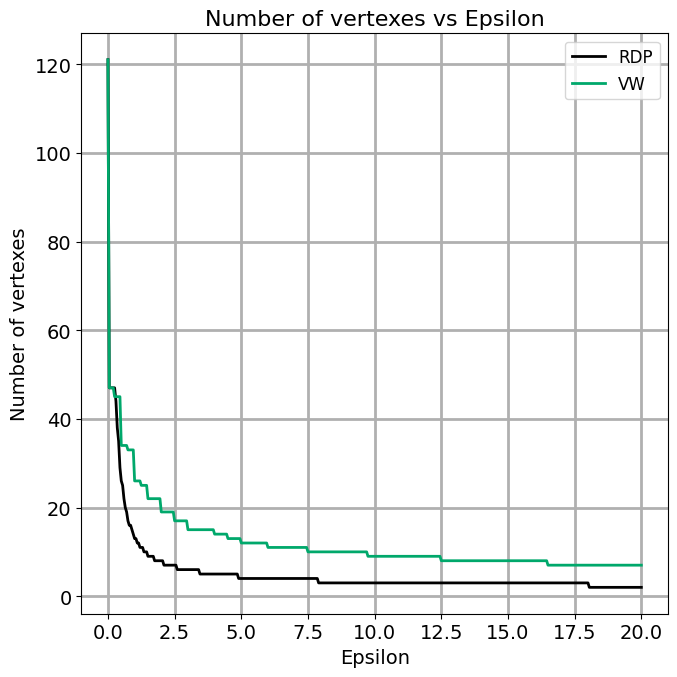

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))


set_limit = len(x)
ax.plot(x[:set_limit],num_points_dp[:set_limit], label = "RDP", color='black', linestyle='-', linewidth=2)
ax.plot(x[:set_limit],num_points_vw[:set_limit], label = "VW", color='#00a86b', linestyle='-', linewidth=2)
# ax.plot([0.05]*120,range(0,120), color='red', linestyle='-.', linewidth=2)
ax.legend(fontsize=12)
ax.set_xlabel("Epsilon",fontsize=14)
ax.set_ylabel("Number of vertexes",fontsize=14)
ax.set_title("Number of vertexes vs Epsilon",fontsize=16)
ax.grid(True,linewidth = 2)


plt.tight_layout()
plt.show()

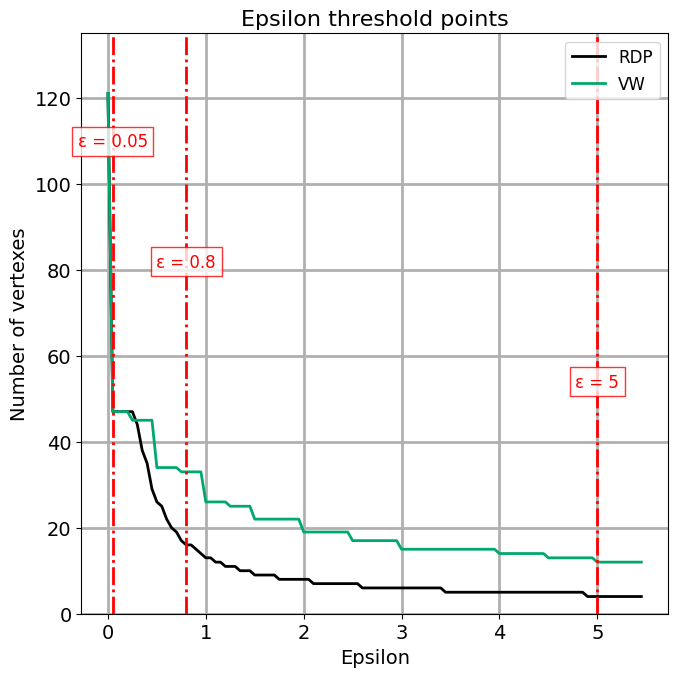

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

Y_MAX_LIMIT = 140
set_limit = 110

# Данные для графиков
ax.plot(x[:set_limit], num_points_dp[:set_limit], label="RDP", color='black', linestyle='-', linewidth=2)
ax.plot(x[:set_limit], num_points_vw[:set_limit], label="VW", color='#00a86b', linestyle='-', linewidth=2)

# Линии порогов
thresholds = [0.05, 0.8, 5]
spacing = Y_MAX_LIMIT // (len(thresholds) + 2)  # Расстояние между подписями

for idx, t in enumerate(thresholds):
    ax.plot([t] * Y_MAX_LIMIT, range(0, Y_MAX_LIMIT), color='red', linestyle='-.', linewidth=2)

    # Подписываем каждую точку на разной высоте
    label_y = Y_MAX_LIMIT - (idx + 1) * spacing  # Размещаем подписи равномерно сверху вниз
    ax.text(t, label_y, f"ε = {t}", color='red', fontsize=12, ha='center', va='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

# Настройки графика
ax.legend(fontsize=12, loc=1)
ax.set_xlabel("Epsilon", fontsize=14)
ax.set_ylabel("Number of vertexes", fontsize=14)
ax.set_title("Epsilon threshold points", fontsize=16)
ax.set_ylim(0, Y_MAX_LIMIT-5)
# ax.set_xlim(-0.8)
ax.grid(True, linewidth=2)

plt.tight_layout()
plt.show()


In [ ]:
get_metrics_all(predict_mask_list,0,0)

100%|██████████| 117/117 [00:00<00:00, 375.76it/s]


{'num_points_mask': 3401,
 'dice_dp': 1.0,
 'iou_dp': 1.0,
 'num_points_dp': 121,
 'dice_vw': 1.0,
 'iou_vw': 1.0,
 'num_points_vw': 121}

In [ ]:
for i,point in enumerate(num_points_dp):
    
    print(f"index = {i}, Num_points = {point} for eps = {i*0.05} ")

index = 0, Num_points = 121 for eps = 0.0 
index = 1, Num_points = 47 for eps = 0.05 
index = 2, Num_points = 47 for eps = 0.1 
index = 3, Num_points = 47 for eps = 0.15000000000000002 
index = 4, Num_points = 47 for eps = 0.2 
index = 5, Num_points = 47 for eps = 0.25 
index = 6, Num_points = 44 for eps = 0.30000000000000004 
index = 7, Num_points = 38 for eps = 0.35000000000000003 
index = 8, Num_points = 35 for eps = 0.4 
index = 9, Num_points = 29 for eps = 0.45 
index = 10, Num_points = 26 for eps = 0.5 
index = 11, Num_points = 25 for eps = 0.55 
index = 12, Num_points = 22 for eps = 0.6000000000000001 
index = 13, Num_points = 20 for eps = 0.65 
index = 14, Num_points = 19 for eps = 0.7000000000000001 
index = 15, Num_points = 17 for eps = 0.75 
index = 16, Num_points = 16 for eps = 0.8 
index = 17, Num_points = 16 for eps = 0.8500000000000001 
index = 18, Num_points = 15 for eps = 0.9 
index = 19, Num_points = 14 for eps = 0.9500000000000001 
index = 20, Num_points = 13 for eps

In [ ]:
for i,point in enumerate(num_points_vw):
    print(f"index = {i}, Num_points = {point} for eps = {i*0.05} ")

index = 0, Num_points = 121 for eps = 0.0 
index = 1, Num_points = 47 for eps = 0.05 
index = 2, Num_points = 47 for eps = 0.1 
index = 3, Num_points = 47 for eps = 0.15000000000000002 
index = 4, Num_points = 47 for eps = 0.2 
index = 5, Num_points = 45 for eps = 0.25 
index = 6, Num_points = 45 for eps = 0.30000000000000004 
index = 7, Num_points = 45 for eps = 0.35000000000000003 
index = 8, Num_points = 45 for eps = 0.4 
index = 9, Num_points = 45 for eps = 0.45 
index = 10, Num_points = 34 for eps = 0.5 
index = 11, Num_points = 34 for eps = 0.55 
index = 12, Num_points = 34 for eps = 0.6000000000000001 
index = 13, Num_points = 34 for eps = 0.65 
index = 14, Num_points = 34 for eps = 0.7000000000000001 
index = 15, Num_points = 33 for eps = 0.75 
index = 16, Num_points = 33 for eps = 0.8 
index = 17, Num_points = 33 for eps = 0.8500000000000001 
index = 18, Num_points = 33 for eps = 0.9 
index = 19, Num_points = 33 for eps = 0.9500000000000001 
index = 20, Num_points = 26 for eps

In [ ]:
eps = 5
get_metrics_all(predict_mask_list,eps,eps)

100%|██████████| 117/117 [00:00<00:00, 366.57it/s]


{'num_points_mask': 3401,
 'dice_dp': 0.8542087718888521,
 'iou_dp': 0.7719411714953907,
 'num_points_dp': 4,
 'dice_vw': 0.9316619368960718,
 'iou_vw': 0.8961991531313278,
 'num_points_vw': 12}

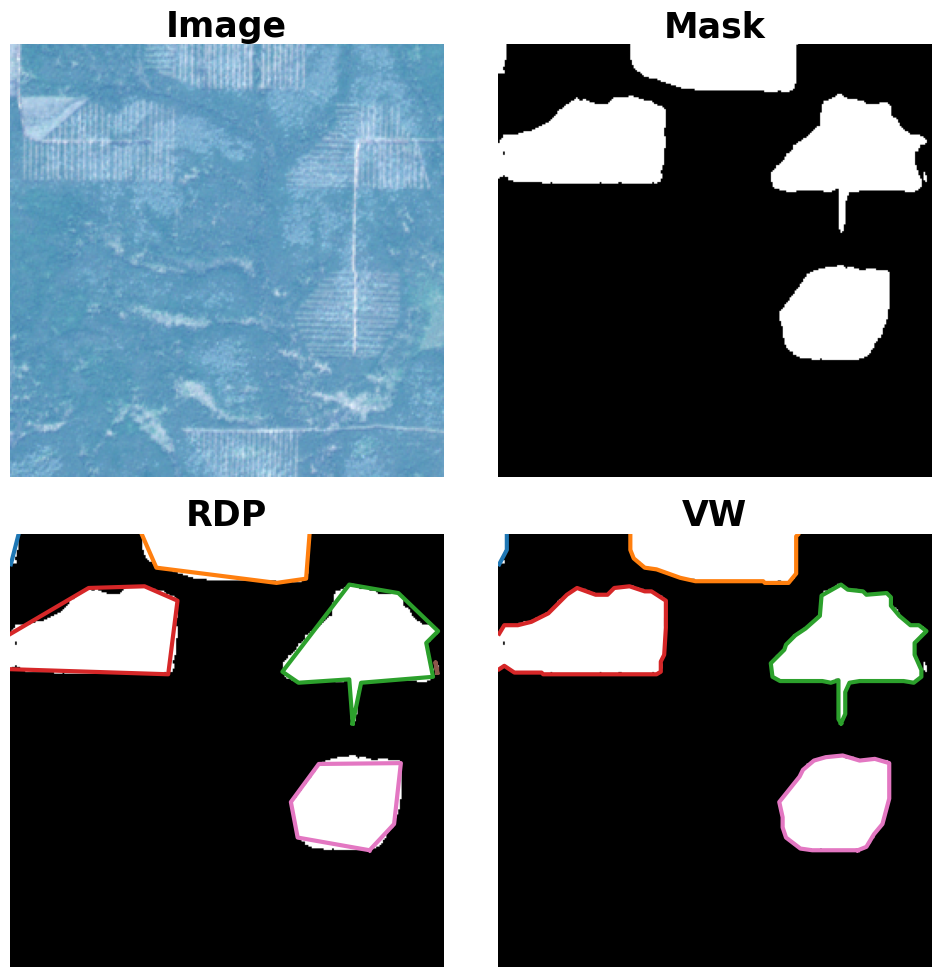

In [ ]:

test_mask = (predict_mask_list[48]*65536).astype(int )    #24 25
test_mask[test_mask>1]=1
contours = get_contours(test_mask)

fig, ax = plt.subplots(2,2,figsize=(10,10))

img = io.imread(r'tiles_256_256_27_test\T38VNQ_pair_3_20200503_20210513\T38VNQ_pair_3_20200503_20210513_4523_3308_with_object.tif')


ax[0,0].imshow(get_rgb_new(img))
# show_img_norm(get_rgb_old(img), 0)
ax[0,0].set_title('Image',fontsize=25,weight='bold')
ax[0,0].axis("off")


ax[0,1].imshow(test_mask,cmap="gray")
ax[0,1].set_title('Mask',fontsize=25,weight='bold')
ax[0,1].axis("off")
for c in contours:

    test_contour = c
    tolerance = 5
    polygon_dp = simplify_coords(test_contour,tolerance) #Дуглас-Пеккер
    polygon_vw = simplify_coords_vw(test_contour,tolerance) #Висвалингам-Уатт
    # print(polygon_dp.shape, polygon_vw.shape)

    
    ax[1,0].imshow(test_mask,cmap="gray")
    ax[1,0].plot(polygon_dp[:,0], polygon_dp[:,1],linewidth=3)
    ax[1,0].set_title('RDP',fontsize=25,weight='bold')
    ax[1,0].axis("off")
    
    ax[1,1].imshow(test_mask, cmap="gray")
    ax[1,1].set_title('VW',fontsize=25,weight='bold')
    ax[1,1].plot(polygon_vw[:,0], polygon_vw[:,1],linewidth=3)
    
    ax[1,1].axis("off")
plt.tight_layout()
plt.show()
    

In [ ]:
# for tileS in random.sample(allTiles,5):
#     print(tileS)
#     img = io.imread(tileS)

#     fig,axes = plt.subplots(ncols=3,figsize=(50,50))
#     plt.title(os.path.basename(tileS))

#     show_img_norm(get_rgb_old(img), 0)
#     axes[0].set_title(f'{tileS}',fontsize=16,weight='bold')

#     show_img_norm(get_rgb_new(img), 1)
#     axes[1].set_title('New image', fontsize=30,weight='bold')

#     show_mask( img[:,:,0], 2)